# Object Detection với Open CV

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

## 1. Module Video Analysis
* Object Tracking

### Object Tracking
* cv2.calcOpticalFlowPyrLK() : Object tracking with Lucas Kanade
* cv2.calcOpticalFlowFarneback(): Object tracking with Dense Optical Flow
* cv2.CamShift(): Find object with fit border
* cv2.meanShift(): Normally find object

#### 1.1 Object tracking
* cv2.calcOpticalFlowPyrLK()
* cv2.calcOpticalFlowFarneback()

In [4]:
# Lucas Kanade object tracking
corner_track_params = dict(maxCorners = 20,qualityLevel = 0.3, minDistance=7,blockSize=7)
lk_params = dict(winSize=(200,200),maxLevel = 2,criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03))

In [5]:
cap = cv2.VideoCapture(0)
ret, prev_frame = cap.read()
prev_gray = cv2.cvtColor(prev_frame,cv2.COLOR_BGR2GRAY)

prevPts = cv2.goodFeaturesToTrack(prev_gray,mask = None,**corner_track_params)

mask = np.zeros_like(prev_frame)

while True:
    ret , frame = cap.read()

    frame_gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    nextPts , status, err = cv2.calcOpticalFlowPyrLK(prev_gray,frame_gray,prevPts,None,**lk_params)

    good_new = nextPts[status==1]
    good_prev = prevPts[status==1]

    for i,(new,prev) in enumerate(zip(good_new,good_prev)):
        x_new, y_new = new.ravel()
        x_prev, y_prev = prev.ravel()

        mask = cv2.line(mask,(int(x_new),int(y_new)),(int(x_prev),int(y_prev)),(0,255,0),3)
        frame = cv2.circle(frame,(int(x_new),int(y_new)),8,(0,0,255),-1)

    img = cv2.add(frame,mask)
    cv2.imshow('tracking',img)

    k = cv2.waitKey(30) & 0xFF
    if k == ord('q'):
        break

    prev_gray = frame_gray.copy()
    prevPts = good_new.reshape(-1,1,2)

cv2.destroyAllWindows()
cap.release()

In [6]:
# Dense Optical Flow
# Capture the frame
cap = cv2.VideoCapture(0)
ret, frame1 = cap.read()

# Get gray scale image of first frame and make a mask in HSV color
prvsImg = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

hsv_mask = np.zeros_like(frame1)
hsv_mask[:,:,1] = 255

while True:
    ret, frame2 = cap.read()
    nextImg = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    
    # Check out the markdown text above for a break down of these paramters, most of these are just suggested defaults
    flow = cv2.calcOpticalFlowFarneback(prvsImg,nextImg, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    
    
    # Color the channels based on the angle of travel
    # Pay close attention to your video, the path of the direction of flow will determine color!
    mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1],angleInDegrees=True)
    hsv_mask[:,:,0] = ang/2
    hsv_mask[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # Convert back to BGR to show with imshow from cv
    bgr = cv2.cvtColor(hsv_mask,cv2.COLOR_HSV2BGR)
    cv2.imshow('frame2',bgr)
    
    k = cv2.waitKey(30) & 0xff
    if k == ord('q'):
        break
    
    # Set the Previous image as the next iamge for the loop
    prvsImg = nextImg

    
cap.release()
cv2.destroyAllWindows()

### 1.2 : Object detect
* cv2.meanShift()
* cv2.CamShift()

In [10]:
# mean shift
# Capture a video stream
cap = cv2.VideoCapture(0)

# take first frame of the video
ret,frame = cap.read()


# Set Up the Initial Tracking Window


# We will first detect the face and set that as our starting box.
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
face_rects = face_cascade.detectMultiScale(frame) 

# Convert this list of a single array to a tuple of (x,y,w,h)
(face_x,face_y,w,h) = tuple(face_rects[0]) 
track_window = (face_x,face_y,w,h)
# set up the ROI for tracking
roi = frame[face_y:face_y+h, face_x:face_x+w]


# Use the HSV Color Mapping
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Find histogram to backproject the target on each frame for calculation of meanshit
roi_hist = cv2.calcHist([hsv_roi],[0],None,[180],[0,180])

# Normalize the histogram array values given a min of 0 and max of 255
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)


# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
    ret ,frame = cap.read()
    if ret == True:
        
        # Grab the Frame in HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Calculate the Back Projection based off the roi_hist created earlier
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        # Apply meanshift to get the new coordinates of the rectangle
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        
        # Draw the new rectangle on the image
        x,y,w,h = track_window
        img2 = cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255),5)
        
        cv2.imshow('img2',img2)
        
        
        k = cv2.waitKey(1) & 0xff
        if k == ord('q'):
            break
        
    else:
        break
        
cv2.destroyAllWindows()
cap.release()

In [12]:
# Cam shift
# Capture a video stream
cap = cv2.VideoCapture(0)

# take first frame of the video
ret,frame = cap.read()


# Set Up the Initial Tracking Window


# We will first detect the face and set that as our starting box.
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')
face_rects = face_cascade.detectMultiScale(frame) 

# Convert this list of a single array to a tuple of (x,y,w,h)
(face_x,face_y,w,h) = tuple(face_rects[0]) 
track_window = (face_x,face_y,w,h)
# set up the ROI for tracking
roi = frame[face_y:face_y+h, face_x:face_x+w]


# Use the HSV Color Mapping
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

# Find histogram to backproject the target on each frame for calculation of meanshit
roi_hist = cv2.calcHist([hsv_roi],[0],None,[180],[0,180])

# Normalize the histogram array values given a min of 0 and max of 255
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)


# Setup the termination criteria, either 10 iteration or move by at least 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

while True:
    ret ,frame = cap.read()
    if ret == True:
        
        # Grab the Frame in HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        
        # Calculate the Back Projection based off the roi_hist created earlier
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        
        #########################################################
        #########################################################
        ########## CAM SHIFT ####################################
        ########################################################
        #######################################################
        
        # Apply Camshift to get the new coordinates of the rectangle
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
        
        # Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, (0,0,255),5)
        cv2.imshow('img2',img2)
        
        ########################################################
        #######################################################
        ########################################################
        #######################################################
        
        k = cv2.waitKey(1) & 0xff
        if k == ord('q'):
            break
        
    else:
        break
        
cv2.destroyAllWindows()
cap.release()

## 2. Module Tracking APIs
* cv2.legacy.TrackerBoosting_create()
* cv2.TrackerMIL_create()
* cv2.TrackerKCF_create()
* cv2.legacy.TrackerTLD_create()
* cv2.legacy.TrackerMedianFlow_create()

In [13]:
def ask_for_tracker():
    print("Welcome! What Tracker API would you like to use?")
    print("Enter 0 for BOOSTING: ")
    print("Enter 1 for MIL: ")
    print("Enter 2 for KCF: ")
    print("Enter 3 for TLD: ")
    print("Enter 4 for MEDIANFLOW: ")
    choice = input("Please select your tracker: ")
    
    if choice == '0':
        tracker = cv2.legacy.TrackerBoosting_create()
    if choice == '1':
        tracker = cv2.TrackerMIL_create()
    if choice == '2':
        tracker = cv2.TrackerKCF_create()
    if choice == '3':
        tracker = cv2.legacy.TrackerTLD_create()
    if choice == '4':
        tracker = cv2.legacy.TrackerMedianFlow_create()


    return tracker

In [14]:
tracker = ask_for_tracker()
tracker_name = str(tracker).split()[0][1:]

# Read video
cap = cv2.VideoCapture(0)

# Read first frame.
ret, frame = cap.read()


# Special function allows us to draw on the very first frame our desired ROI
roi = cv2.selectROI(frame, False)

# Initialize tracker with first frame and bounding box
ret = tracker.init(frame, roi)

while True:
    # Read a new frame
    ret, frame = cap.read()
    
    
    # Update tracker
    success, roi = tracker.update(frame)
    
    # roi variable is a tuple of 4 floats
    # We need each value and we need them as integers
    (x,y,w,h) = tuple(map(int,roi))
    
    # Draw Rectangle as Tracker moves
    if success:
        # Tracking success
        p1 = (x, y)
        p2 = (x+w, y+h)
        cv2.rectangle(frame, p1, p2, (0,255,0), 3)
    else :
        # Tracking failure
        cv2.putText(frame, "Failure to Detect Tracking!!", (100,200), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),3)

    # Display tracker type on frame
    cv2.putText(frame, tracker_name, (20,400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0),3)

    # Display result
    cv2.imshow(tracker_name, frame)

    # Exit if q pressed
    k = cv2.waitKey(1) & 0xff
    if k == ord('q') : 
        break
        
cap.release()
cv2.destroyAllWindows()

Welcome! What Tracker API would you like to use?
Enter 0 for BOOSTING: 
Enter 1 for MIL: 
Enter 2 for KCF: 
Enter 3 for TLD: 
Enter 4 for MEDIANFLOW: 


## 3. Module Object Detection
* Class: 
1. Cascade Classifier: Perform Haar Casscade Detection
2. QRcode Detector : Perform QR code detector
3. QRcode Decoder : Perform QR code decoder


### 3.1 Perform Detection with Haar Cascade
* cv2.CascadeClassifier('path to haar cascade') : load a haar cascade
* cv2.CascadeClassifier('path to haar cascade').detectMultiScale(image,ScaleFactor,minNeighbors): perform detection
* Important parameters:
1. ScaleFactor: how reduction the crop anchor pass into haarcascade, must >1 (recomend 1.05-1.2)
2. minNeghibor: trading between ddetection quantities and quality, higher value better quality but less detection (rec: 3-6)

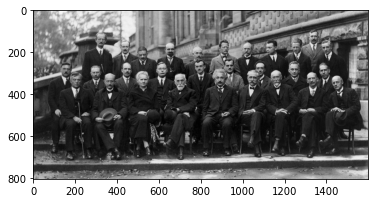

In [7]:
nadia  = cv2.imread('DATA/raw/Nadia_Murad.jpg',0)
denis = cv2.imread('DATA/raw/Denis_Mukwege.jpg',0)
solvay = cv2.imread('DATA/raw/solvay_conference.jpg',0)
plt.imshow(solvay,cmap='gray')

In [4]:
face_cascade = cv2.CascadeClassifier('haarcascades\haarcascade_frontalface_default.xml')

In [8]:
# face detect funtion
def adj_detect_face(img,scale,minnb):
    face_img = img.copy()

    face_rects = face_cascade.detectMultiScale(face_img,scaleFactor=scale,minNeighbors=minnb)

    for (x,y,h,w) in face_rects:
        cv2.rectangle(face_img,(x,y),(x+w,y+h),(255,255,255),10)

    return face_img

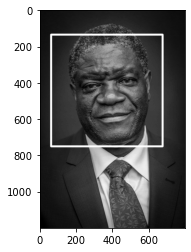

In [38]:
result = adj_detect_face(denis,scale=1.5,minnb=5)
plt.imshow(result,cmap='gray')

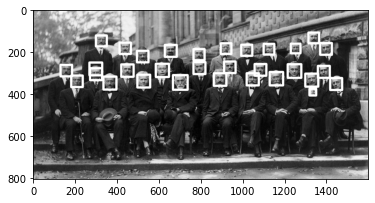

In [33]:
result = adj_detect_face(solvay,scale=1.1,minnb=5)
plt.imshow(result,cmap='gray')

In [19]:
eye_cascade = cv2.CascadeClassifier('haarcascades\haarcascade_eye.xml')

In [20]:
def adj_detect_eyes(img,scale,minnb):
    face_img = img.copy()

    eye_rects = eye_cascade.detectMultiScale(face_img,scaleFactor=scale,minNeighbors=minnb)

    for (x,y,h,w) in eye_rects:
        cv2.rectangle(face_img,(x,y),(x+w,y+h),(255,255,255),10)

    return face_img

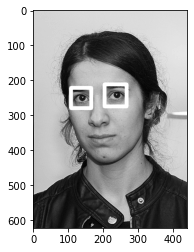

In [29]:
result = adj_detect_eyes(nadia,1.2,8)
plt.imshow(result,cmap='gray')

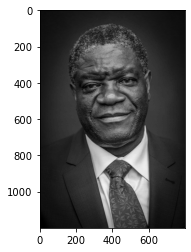

In [24]:
result = adj_detect_eyes(denis,1.05,3)
plt.imshow(result,cmap='gray')

In [35]:
# live camera detection
cap = cv2.VideoCapture(0)

while True:
    ret,frame = cap.read(0)

    frame = adj_detect_face(frame,1.2,5)
    frame = adj_detect_eyes(frame,2,8)

    cv2.imshow('Video Face Detect',frame)

    k = cv2.waitKey(1)

    if k==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### 3.2: Working with QR Code


* cv2.QRCodeDetector().decode(): decode the QRcode to string
* cv2.QRCodeDetector().detect(): detect QR code, return the boundary
* cv2.QRCodeDetector().detectAndDecode(): combine 2 step



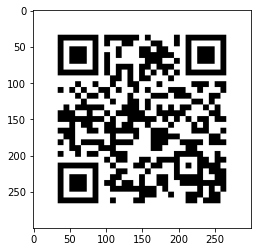

In [80]:
qr_code = cv2.imread('DATA/raw/qrcodeopencv.png',)
# gray_qr_code = cv2.cvtColor(qr_code,cv2.COLOR_BGR2GRAY)
plt.imshow(qr_code,cmap='gray')

In [44]:
QR_detector = cv2.QRCodeDetector()

In [84]:
# detect the QRcode
isDetected,boundary = QR_detector.detect(qr_code)
boundary, boundary.shape

(array([[[ 34.,  34.],
         [265.,  34.],
         [265., 265.],
         [ 34., 265.]]], dtype=float32),
 (1, 4, 2))

In [57]:
# decode the QRcode retrurn decode string and the QRcode
qr_string,straight_qr_code = QR_detector.decode(qr_code,boundary)
qr_string

'My name is Viet'

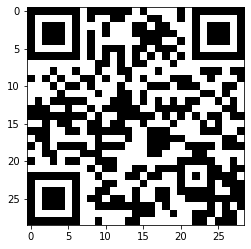

In [50]:
plt.imshow(straight_qr_code, cmap='gray')

In [68]:
# combine 2 step 
data, bound, rectified_img = QR_detector.detectAndDecode(qr_code)
bound = bound.astype(np.int32)
bound

array([[[ 34,  34],
        [265,  34],
        [265, 265],
        [ 34, 265]]])

In [93]:
def extract_qr_code(qr_code_img,QR_detector):
    data,bound,rectified_img = QR_detector.detectAndDecode(qr_code_img)
    copy_img = qr_code_img.copy()
    print(f"Content of QR code is: {data}")
    try:
        cv2.polylines(copy_img,[bound.astype(np.int32)],isClosed=True,color=(0,0,255),thickness=5)
        plt.imshow(copy_img)
        return data,copy_img
    except:
        return data,None

('My name is Viet',
 array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
        

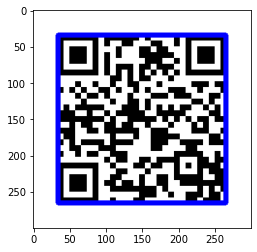

In [92]:
extract_qr_code(qr_code,QR_detector)

In [95]:
# # live qr_code detect
# # live camera detection
# cap = cv2.VideoCapture(0)

# while True:
#     ret,frame = cap.read(0)
#     try:
#         content,frame = extract_qr_code(frame,QR_detector)
#         cv2.imshow('Video QRcode Detect',frame)
#     except:
#         ret,frame = cap.read(0)
#         cv2.imshow('Video QRcode Detect',frame)
#     k = cv2.waitKey(1)

#     if k==ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

## 4. Module 2D Features Framework
* Feature Detection and description: Feature dectection for feature matching
* Descriptor Matcher: Matcher for feature matching in object detector
* Drawing Function of Keypoint and Matches: draw keypoint and match line for feature matching
* Object Categorization: Image descriptor

### 4.1 Feature Matching for object detection and drawing keypont, mtach in matching
* funtion for feature detection in feature matching:
1. cv2.ORB_create(): ORN feature detectect for feature matching
2. cv2.xfeature2d.SIFT_create() : SIFT feature for feature matching
3. cv2.KAZE_create(): KAZE feature detection for feature matching


* class for feature matching:
1. cv2.BFMatcher() : BruteForce matcher for feature matching 
2. cv2.FlannBasedMatcher() : Flann Based Matcher for feature matching
3. cv2.DescriptorMatcher() : Descriptor Matcher for feature matching

* Funtions:
1. cv2.drawKeypoints()
2. cv2.drawMatches()
3. cv2._____Matcher().match(): matching for ORB keypoint
4. cv2._____Matcher().knnMatch(): MAtching for SIFT keypoint
5. cv2.keypoint___create().detectAndCompute(): detect keypoint for feature matching

In [96]:
def display(img,cmap='gray'):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

In [97]:
reese = cv2.imread('DATA/raw/reeses_puffs.png',0)
cereals = cv2.imread('DATA/raw/many_cereals.jpg',0)

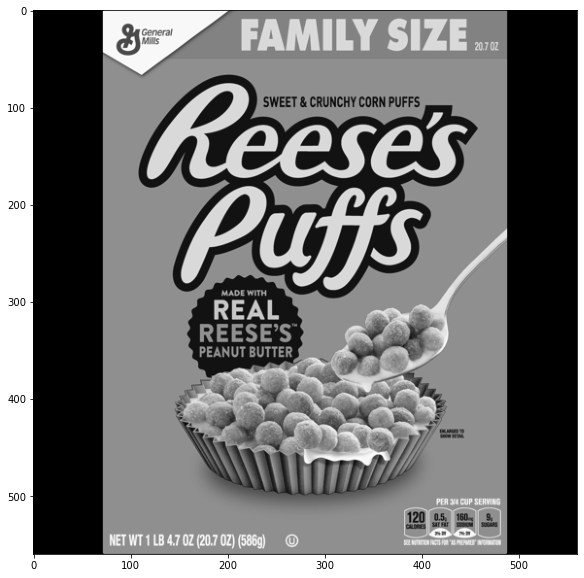

In [100]:
display(reese)

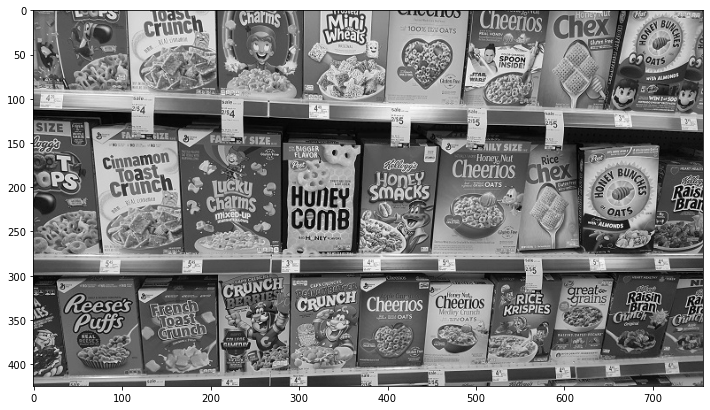

In [101]:
display(cereals)

In [109]:
## Brute-force matcher with ORB keypoint
orb = cv2.ORB_create()
kp1,des1 = orb.detectAndCompute(reese,None)
kp2,des2 = orb.detectAndCompute(cereals,None)

In [113]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=True)
matches = bf.match(des1,des2)
matches = sorted(matches,key = lambda x:x.distance)

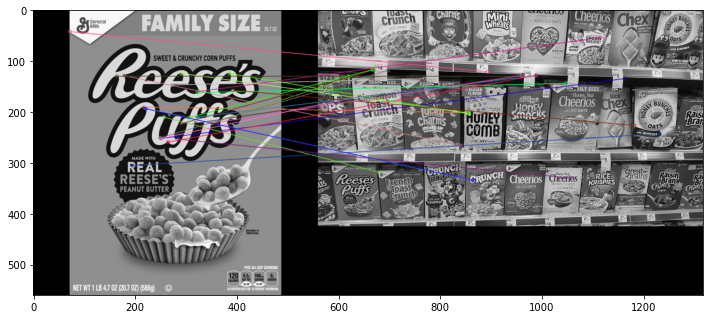

In [114]:
reese_matches = cv2.drawMatches(reese,kp1,cereals,kp2,matches[:25],None,flags=2)
display(reese_matches)

In [105]:
## Brute-fore matching wwith SIFT keypoint
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(reese,None)
kp2,des2 = sift.detectAndCompute(cereals,None)

In [106]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

In [107]:
good = []
for match1,match2 in matches:
    if match1.distance < 0.75*match2.distance:
        good.append([match1])
len(good) ,len(matches)

(79, 1501)

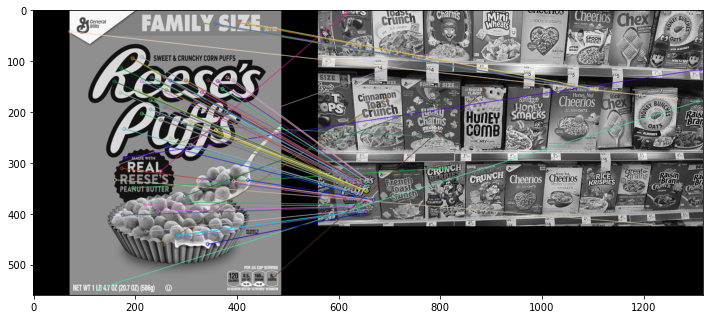

In [108]:
sift_matches = cv2.drawMatchesKnn(reese,kp1,cereals,kp2,good,None,flags=2)
display(sift_matches)

In [115]:
### Flann- based matcher
sift = cv2.xfeatures2d.SIFT_create()
kp1,des1 = sift.detectAndCompute(reese,None)
kp2,des2 = sift.detectAndCompute(cereals,None)

In [116]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE,trees=5)
search_params = dict(checks=50)

In [117]:
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

In [118]:
matchesMask = [[0,0] for i in range(len(matches))]
for i,(match1,match2) in enumerate(matches):
    if match1.distance < 0.7*match2.distance:
        matchesMask[i] = [1,0]

In [119]:
draw_prams = dict(matchColor=(0,255,0),singlePointColor=(255,0,0),matchesMask=matchesMask,flags = 0)

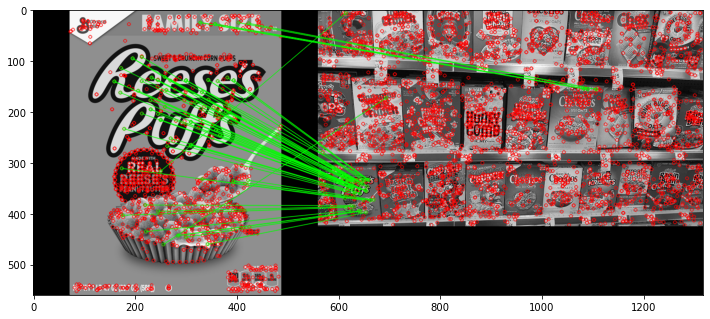

In [120]:
flann_matches = cv2.drawMatchesKnn(reese,kp1,cereals,kp2,matches,None,**draw_prams)
display(flann_matches)